In [1]:
# libraries
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import time 
import tqdm
from PIL import Image
train_on_gpu = True
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

import cv2
import albumentations
from albumentations import torch as AT

## Data overview

In [2]:
train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
sample_submission = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')

In [3]:
train.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


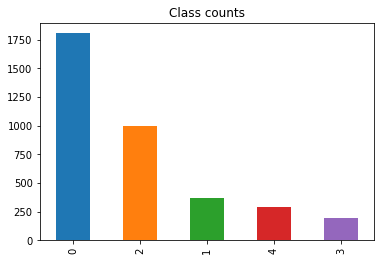

In [4]:
train['diagnosis'].value_counts().plot(kind='bar');
plt.title('Class counts');

We have a slight disbalance in data.

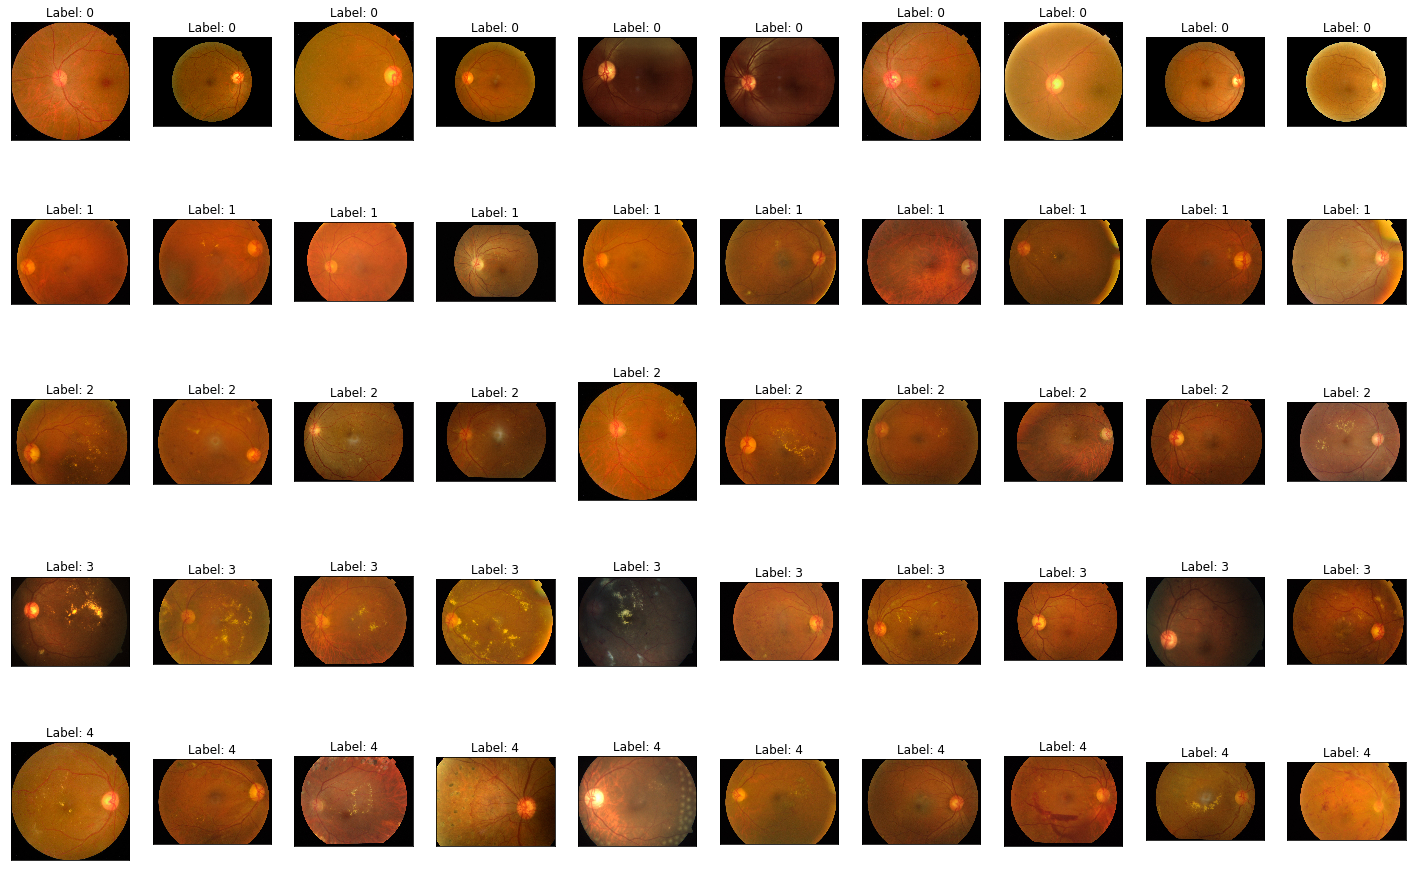

In [5]:
fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for class_id in sorted(train['diagnosis'].unique()):
    for i, (idx, row) in enumerate(train.loc[train['diagnosis'] == class_id].sample(10).iterrows()):
        ax = fig.add_subplot(5, 10, class_id * 10 + i + 1, xticks=[], yticks=[])
        im = Image.open(f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png")
        plt.imshow(im)
        ax.set_title(f'Label: {class_id}')

Personally I see little differences between images

## Data preparation

In [6]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
def prepare_labels(y):
    # From here: https://www.kaggle.com/pestipeti/keras-cnn-starter
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    y = onehot_encoded
    return y, label_encoder

In [7]:
y, le = prepare_labels(train['diagnosis'])

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [8]:
class GlassDataset(Dataset):
    def __init__(self, df, datatype='train', transform = transforms.Compose([transforms.CenterCrop(32),transforms.ToTensor()]), y = None):
        self.df = df
        self.datatype = datatype
        self.image_files_list = [f'../input/aptos2019-blindness-detection/{self.datatype}_images/{i}.png' for i in df['id_code'].values]
        if self.datatype == 'train':
            self.labels = y
        else:
            self.labels = np.zeros((df.shape[0], 5))
        self.transform = transform

    def __len__(self):
        return len(self.image_files_list)

    def __getitem__(self, idx):
        img_name = self.image_files_list[idx]
        img = cv2.imread(img_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image = self.transform(image=img)
        image = image['image']

        img_name_short = self.image_files_list[idx].split('.')[0]

        label = self.labels[idx]
        if self.datatype == 'test':
            return image, label, img_name
        else:
            return image, label

In [9]:
data_transforms = albumentations.Compose([
    albumentations.Resize(224, 224),
    albumentations.RandomRotate90(p=0.5),
    albumentations.Transpose(p=0.5),
    albumentations.Flip(p=0.5),
    albumentations.OneOf([
        albumentations.CLAHE(clip_limit=2), albumentations.RandomBrightness(), albumentations.RandomContrast(),
        albumentations.JpegCompression(), albumentations.Blur(), albumentations.GaussNoise()], p=0.5), 
    albumentations.HueSaturationValue(p=0.5), 
    albumentations.ShiftScaleRotate(shift_limit=0.15, scale_limit=0.15, rotate_limit=45, p=0.5),
    albumentations.Normalize(),
    AT.ToTensor()
    ])

data_transforms_test = albumentations.Compose([
    albumentations.Resize(224, 224),
    albumentations.Normalize(),
    AT.ToTensor()
    ])

dataset = GlassDataset(df=train, datatype='train', transform=data_transforms, y=y)
test_set = GlassDataset(df=test, datatype='test', transform=data_transforms_test)
tr, val = train_test_split(train.diagnosis, stratify=train.diagnosis, test_size=0.1)
train_sampler = SubsetRandomSampler(list(tr.index))
valid_sampler = SubsetRandomSampler(list(val.index))
batch_size = 24
test_batch_size = 32
num_workers = 0
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size, num_workers=num_workers)

In [10]:
from torchvision.models.resnet import ResNet, Bottleneck

def _resnext(arch, block, layers, pretrained, **kwargs):
    model = ResNet(block, layers, **kwargs)
    return model

def resnext101_32x8d(**kwargs):
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnext('resnext101_32x8d', Bottleneck, [3, 4, 23, 3], True, **kwargs)

model_conv = resnext101_32x8d()
model_conv.load_state_dict(torch.load('../input/resnext101wsl/ig_resnext101_32x8-c38310e5.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [11]:
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 5)

In [12]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma

    def forward(self, logit, target):
        target = target.float()
        max_val = (-logit).clamp(min=0)
        loss = logit - logit * target + max_val + \
               ((-max_val).exp() + (-logit - max_val).exp()).log()

        invprobs = F.logsigmoid(-logit * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        if len(loss.size())==2:
            loss = loss.sum(dim=1)
        return loss.mean()

In [13]:
model_conv.cuda()
criterion = nn.BCEWithLogitsLoss()

#optimizer = optim.SGD(model_conv.fc.parameters(), lr=0.005, momentum=0.99)
#scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2, )

plist = [
         {'params': model_conv.layer4.parameters(), 'lr': 1e-4, 'weight': 0.001},
         {'params': model_conv.fc.parameters(), 'lr': 1e-3}
         ]

optimizer = optim.Adam(model_conv.fc.parameters(), lr=0.002)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.5)

## Model training

In [14]:
valid_loss_min = np.Inf
patience = 6
# current number of epochs, where validation loss didn't increase
p = 0
# whether training should be stopped
stop = False

# number of epochs to train the model
n_epochs = 64
for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)
    model_conv.train()
    
    if epoch==4:
        optimizer = optim.Adam(plist, lr=0.001)
        scheduler = lr_scheduler.StepLR(optimizer, step_size = 2, gamma = 0.5)
    if epoch==12:
        optimizer = optim.SGD(model_conv.parameters(), lr=1e-6)
        scheduler = lr_scheduler.StepLR(optimizer, step_size = 2, gamma = 0.5)

    train_loss = []
    train_auc = []
    for batch_i, (data, target) in enumerate(train_loader):

        data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model_conv(data)
        loss = criterion(output, target.float())
        train_loss.append(loss.item())
        
        a = target.data.cpu().numpy()
        b = output[:,-1].detach().cpu().numpy()
        # train_auc.append(roc_auc_score(a, b))
        loss.backward()
        optimizer.step()
    
    model_conv.eval()
    val_loss = []
    val_auc = []
    for batch_i, (data, target) in enumerate(valid_loader):
        data, target = data.cuda(), target.cuda()
        output = model_conv(data)

        loss = criterion(output, target.float())

        val_loss.append(loss.item()) 
        a = target.data.cpu().numpy()
        b = output[:,-1].detach().cpu().numpy()
        # val_auc.append(roc_auc_score(a, b))

    # print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}, train auc: {np.mean(train_auc):.4f}, valid auc: {np.mean(val_auc):.4f}')
    print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}.')
    
    valid_loss = np.mean(val_loss)
    scheduler.step(valid_loss)
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model_conv.state_dict(), 'model.pt')
        valid_loss_min = valid_loss
        p = 0

    # check if validation loss didn't improve
    if valid_loss > valid_loss_min:
        p += 1
        print(f'{p} epochs of increasing val loss')
        if p > patience:
            print('Stopping training')
            stop = True
            break        
            
    if stop:
        break

Sun Jun 30 02:30:09 2019 Epoch: 1
Epoch 1, train loss: 0.3377, valid loss: 0.3127.
Validation loss decreased (inf --> 0.312682).  Saving model ...
Sun Jun 30 02:35:32 2019 Epoch: 2
Epoch 2, train loss: 0.2898, valid loss: 0.2724.
Validation loss decreased (0.312682 --> 0.272368).  Saving model ...
Sun Jun 30 02:41:01 2019 Epoch: 3
Epoch 3, train loss: 0.2877, valid loss: 0.2501.
Validation loss decreased (0.272368 --> 0.250106).  Saving model ...
Sun Jun 30 02:46:24 2019 Epoch: 4
Epoch 4, train loss: 0.2452, valid loss: 0.2193.
Validation loss decreased (0.250106 --> 0.219334).  Saving model ...
Sun Jun 30 02:51:49 2019 Epoch: 5
Epoch 5, train loss: 0.2145, valid loss: 0.2027.
Validation loss decreased (0.219334 --> 0.202718).  Saving model ...
Sun Jun 30 02:57:15 2019 Epoch: 6
Epoch 6, train loss: 0.1967, valid loss: 0.1907.
Validation loss decreased (0.202718 --> 0.190700).  Saving model ...
Sun Jun 30 03:02:42 2019 Epoch: 7
Epoch 7, train loss: 0.1838, valid loss: 0.2187.
1 epochs o

## Predicting

In [15]:
torch.cuda.empty_cache()

In [16]:
sub = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')

model_conv.load_state_dict(torch.load('./model.pt'))
model_conv.eval()

for (data, target, name) in test_loader:
    data = data.cuda()
    output = model_conv(data)
    output = output.cpu().detach().numpy()
    for i, (e, n) in enumerate(list(zip(output, name))):
        sub.loc[sub['id_code'] == n.split('/')[-1].split('.')[0], 'diagnosis'] = le.inverse_transform([np.argmax(e)])
        
sub.to_csv('submission.csv', index=False)

In [17]:
sub.head()

,id_code,diagnosis
0,0005cfc8afb6,1
1,003f0afdcd15,3
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,2


In [18]:
sub['diagnosis'].value_counts()

2    954
0    370
3    299
1    197
4    108
Name: diagnosis, dtype: int64